In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
#from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [13]:
# from google.colab import drive
# drive.mount('/content/drive')

In [14]:
# Reading the datasets
sales_train_evaluation = pd.read_csv('sales_train_evaluation.csv')
sales_train_validation = pd.read_csv('sales_train_validation.csv')
sell_prices = pd.read_csv('sell_prices.csv')
calendar = pd.read_csv('calendar.csv')


In [15]:
# if event_type_1 is null then Normal_day else event_type_1

calendar['event_type_1'] = calendar['event_type_1'].apply(lambda x: 'Normal_day' if pd.isnull(x) else x)
print(calendar.shape)

(1969, 14)


In [16]:
import pandas as pd

# columns drop
columns_to_drop = [f'd_{i}' for i in range(1, 790)]

# Drop the initially identified columns from the DataFrame
sales_train_evaluation = sales_train_evaluation.drop(columns=columns_to_drop)

# Use a while loop to keep checking and dropping
while 'total_sales' in sales_train_evaluation.iloc[0].values:
    # Find column names where 'total_sales' appears in the first row
    columns_with_total_sales = sales_train_evaluation.columns[(sales_train_evaluation.iloc[0] == 'total_sales').values].tolist()

    # Drop these columns from the DataFrame
    sales_train_evaluation = sales_train_evaluation.drop(columns=columns_with_total_sales)


In [17]:
print(sales_train_evaluation.shape)

(30490, 1158)


In [18]:
# Check the last few columns of the DataFrame to ensure consistency
print(sales_train_evaluation.columns[0:10])
print(sales_train_evaluation.columns[-10:])

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd_790',
       'd_791', 'd_792', 'd_793'],
      dtype='object')
Index(['d_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937', 'd_1938',
       'd_1939', 'd_1940', 'd_1941'],
      dtype='object')


In [19]:
# 1) Basic information about data:
print(sales_train_evaluation.info())
print(sell_prices.info())
print(calendar.info())
# Print the list of column names remaining in the DataFrame
# print(sales_train_evaluation_dropped.columns)
# Check the last few columns of the DataFrame to ensure consistency
print(sales_train_evaluation.columns[-10:])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1158 entries, id to d_1941
dtypes: int64(1152), object(6)
memory usage: 269.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_n

In [20]:
#Downcasting
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

sales_train_evaluation = downcast_dtypes(sales_train_evaluation)
sell_prices = downcast_dtypes(sell_prices)
calendar = downcast_dtypes(calendar)
print(sales_train_evaluation.shape)

(30490, 1158)


In [21]:
# Mean sales of products in the USA:
sales_train_evaluation['total_sales'] = sales_train_evaluation.iloc[:, 6:-56].sum(axis=1)
print(sales_train_evaluation['total_sales'].mean())
# Check the last few columns of the DataFrame to ensure consistency
print(sales_train_evaluation.columns[-10:])
print(sales_train_evaluation.shape)

1331.7530337815676
Index(['d_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937', 'd_1938', 'd_1939',
       'd_1940', 'd_1941', 'total_sales'],
      dtype='object')
(30490, 1159)


/tmp/ipykernel_163572/1131403223.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  sales_train_evaluation['total_sales'] = sales_train_evaluation.iloc[:, 6:-56].sum(axis=1)


In [22]:
#Mean sales in every state:
sales_train_evaluation['state_id'] = sales_train_evaluation['id'].str.split('_', expand=True)[3]
mean_sales_by_state = sales_train_evaluation.groupby('state_id')['total_sales'].mean()
print(mean_sales_by_state)
print(sales_train_evaluation.shape)

state_id
CA    1454.175795
TX    1246.675741
WI    1253.599978
Name: total_sales, dtype: float64
(30490, 1159)


In [23]:
#Mean sales in stores:
mean_sales_by_store = sales_train_evaluation.groupby('store_id')['total_sales'].mean()
print(mean_sales_by_store)
# Check the last few columns of the DataFrame to ensure consistency
print(sales_train_evaluation.columns[-10:])
print(sales_train_evaluation.shape)

store_id
CA_1    1567.867826
CA_2    1134.084618
CA_3    2266.098393
CA_4     848.652345
TX_1    1110.888816
TX_2    1387.101673
TX_3    1242.036733
WI_1    1161.075763
WI_2    1465.492293
WI_3    1134.231879
Name: total_sales, dtype: float64
Index(['d_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937', 'd_1938', 'd_1939',
       'd_1940', 'd_1941', 'total_sales'],
      dtype='object')
(30490, 1159)


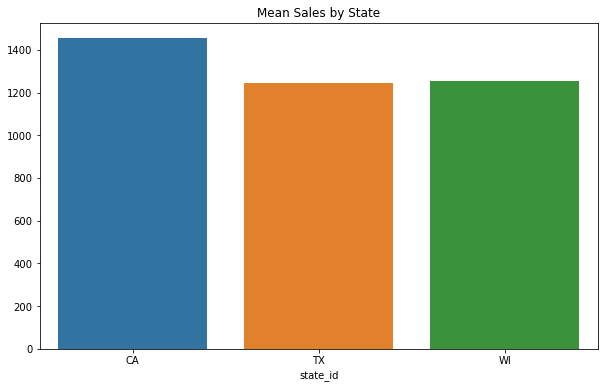

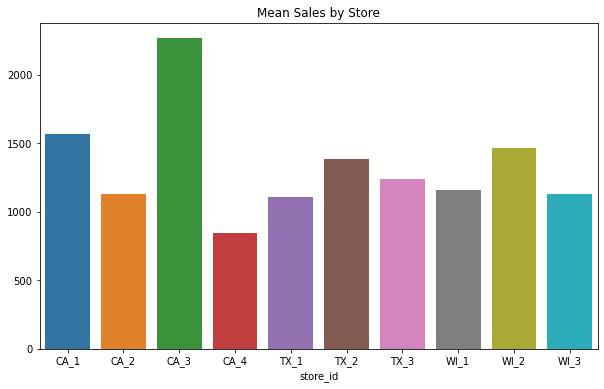

Index(['d_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937', 'd_1938', 'd_1939',
       'd_1940', 'd_1941', 'total_sales'],
      dtype='object')
Index(['d_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937', 'd_1938', 'd_1939',
       'd_1940', 'd_1941', 'total_sales'],
      dtype='object')
(30490, 1159)


In [24]:
# Let's explore sales state-wise and store wise using bar plot:
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_sales_by_state.index, y=mean_sales_by_state.values)
plt.title('Mean Sales by State')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=mean_sales_by_store.index, y=mean_sales_by_store.values)
plt.title('Mean Sales by Store')
plt.show()
# Check the last few columns of the DataFrame to ensure consistency
print(sales_train_evaluation.columns[-10:])
# Check the last few columns of the DataFrame to ensure consistency
print(sales_train_evaluation.columns[-10:])
print(sales_train_evaluation.shape)

In [25]:
# Drop the 'total_sales' column from the DataFrame
sales_train_evaluation = sales_train_evaluation.drop(columns=['total_sales'])

# Verify the last 10 columns to ensure 'total_sales' has been removed
print(sales_train_evaluation.columns[-10:])
print(sales_train_evaluation.shape)

Index(['d_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937', 'd_1938',
       'd_1939', 'd_1940', 'd_1941'],
      dtype='object')
(30490, 1158)


In [26]:
print(sales_train_evaluation)

                                  id        item_id    dept_id   cat_id  \
0      HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1      HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2      HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3      HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4      HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                              ...            ...        ...      ...   
30485    FOODS_3_823_WI_3_evaluation    FOODS_3_823    FOODS_3    FOODS   
30486    FOODS_3_824_WI_3_evaluation    FOODS_3_824    FOODS_3    FOODS   
30487    FOODS_3_825_WI_3_evaluation    FOODS_3_825    FOODS_3    FOODS   
30488    FOODS_3_826_WI_3_evaluation    FOODS_3_826    FOODS_3    FOODS   
30489    FOODS_3_827_WI_3_evaluation    FOODS_3_827    FOODS_3    FOODS   

      store_id state_id  d_790  d_791  d_792  d_793  ...  d_1932  d_1933  \
0         CA_1       CA

In [27]:
# Melt the sales data to have it in long format
sales_long = pd.melt(sales_train_evaluation, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sales')
sales_long
print(sales_long)
print(sales_long.shape)

                                     id        item_id    dept_id   cat_id  \
0         HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1         HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2         HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3         HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4         HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                                 ...            ...        ...      ...   
35124475    FOODS_3_823_WI_3_evaluation    FOODS_3_823    FOODS_3    FOODS   
35124476    FOODS_3_824_WI_3_evaluation    FOODS_3_824    FOODS_3    FOODS   
35124477    FOODS_3_825_WI_3_evaluation    FOODS_3_825    FOODS_3    FOODS   
35124478    FOODS_3_826_WI_3_evaluation    FOODS_3_826    FOODS_3    FOODS   
35124479    FOODS_3_827_WI_3_evaluation    FOODS_3_827    FOODS_3    FOODS   

         store_id state_id       d  sales  
0            CA_1  

In [28]:
# Merge sales data with the calendar to get the date
sales_data_with_date = sales_long.merge(calendar[['d', 'date', 'wm_yr_wk', 'event_name_1', 'event_type_1', 'snap_CA','month']], left_on='d', right_on='d', how='left')
sales_data_with_date
print(sales_data_with_date.shape)
print(sales_data_with_date)


(35124480, 14)
                                     id        item_id    dept_id   cat_id  \
0         HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1         HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2         HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3         HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4         HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                                 ...            ...        ...      ...   
35124475    FOODS_3_823_WI_3_evaluation    FOODS_3_823    FOODS_3    FOODS   
35124476    FOODS_3_824_WI_3_evaluation    FOODS_3_824    FOODS_3    FOODS   
35124477    FOODS_3_825_WI_3_evaluation    FOODS_3_825    FOODS_3    FOODS   
35124478    FOODS_3_826_WI_3_evaluation    FOODS_3_826    FOODS_3    FOODS   
35124479    FOODS_3_827_WI_3_evaluation    FOODS_3_827    FOODS_3    FOODS   

         store_id state_id       d  sales       

In [29]:
print(sales_data_with_date.tail(100))

                                   id      item_id  dept_id cat_id store_id  \
35124380  FOODS_3_726_WI_3_evaluation  FOODS_3_726  FOODS_3  FOODS     WI_3   
35124381  FOODS_3_727_WI_3_evaluation  FOODS_3_727  FOODS_3  FOODS     WI_3   
35124382  FOODS_3_729_WI_3_evaluation  FOODS_3_729  FOODS_3  FOODS     WI_3   
35124383  FOODS_3_730_WI_3_evaluation  FOODS_3_730  FOODS_3  FOODS     WI_3   
35124384  FOODS_3_731_WI_3_evaluation  FOODS_3_731  FOODS_3  FOODS     WI_3   
...                               ...          ...      ...    ...      ...   
35124475  FOODS_3_823_WI_3_evaluation  FOODS_3_823  FOODS_3  FOODS     WI_3   
35124476  FOODS_3_824_WI_3_evaluation  FOODS_3_824  FOODS_3  FOODS     WI_3   
35124477  FOODS_3_825_WI_3_evaluation  FOODS_3_825  FOODS_3  FOODS     WI_3   
35124478  FOODS_3_826_WI_3_evaluation  FOODS_3_826  FOODS_3  FOODS     WI_3   
35124479  FOODS_3_827_WI_3_evaluation  FOODS_3_827  FOODS_3  FOODS     WI_3   

         state_id       d  sales        date  wm_yr

In [30]:
# Convert 'date' to datetime and extract year and month for further analysis
sales_data_with_date['date'] = pd.to_datetime(sales_data_with_date['date'])
print(sales_data_with_date['date'])
sales_data_with_date['year'] = sales_data_with_date['date'].dt.year
sales_data_with_date['month'] = sales_data_with_date['date'].dt.month
print(sales_data_with_date.shape)


0          2013-03-28
1          2013-03-28
2          2013-03-28
3          2013-03-28
4          2013-03-28
              ...    
35124475   2016-05-22
35124476   2016-05-22
35124477   2016-05-22
35124478   2016-05-22
35124479   2016-05-22
Name: date, Length: 35124480, dtype: datetime64[ns]
(35124480, 15)


In [31]:
# 7. Total Sales in Each State, Store, and Product Categories Across All States
filtered_sales_data = sales_data_with_date.iloc[:-56]

total_sales_by_state = filtered_sales_data.groupby('state_id')['sales'].sum().reset_index()
print(total_sales_by_state)
total_sales_by_store = filtered_sales_data.groupby('store_id')['sales'].sum().reset_index()
print(total_sales_by_store)
total_sales_by_cat = filtered_sales_data.groupby('cat_id')['sales'].sum().reset_index()
print(total_sales_by_cat)
sales_by_cat_state = filtered_sales_data.groupby(['state_id', 'cat_id'])['sales'].sum().reset_index()
print(sales_by_cat_state)


  state_id       sales
0       CA  18760469.0
1       TX  12042046.0
2       WI  12217855.0
  store_id      sales
0     CA_1  5042416.0
1     CA_2  3715775.0
2     CA_3  7261666.0
3     CA_4  2740612.0
4     TX_1  3577407.0
5     TX_2  4454637.0
6     TX_3  4010002.0
7     WI_1  3759845.0
8     WI_2  4773322.0
9     WI_3  3684688.0
      cat_id       sales
0      FOODS  28944321.0
1    HOBBIES   4085311.0
2  HOUSEHOLD   9990738.0
  state_id     cat_id       sales
0       CA      FOODS  12258935.0
1       CA    HOBBIES   2034307.0
2       CA  HOUSEHOLD   4467227.0
3       TX      FOODS   7981915.0
4       TX    HOBBIES   1075598.0
5       TX  HOUSEHOLD   2984533.0
6       WI      FOODS   8703471.0
7       WI    HOBBIES    975406.0
8       WI  HOUSEHOLD   2538978.0


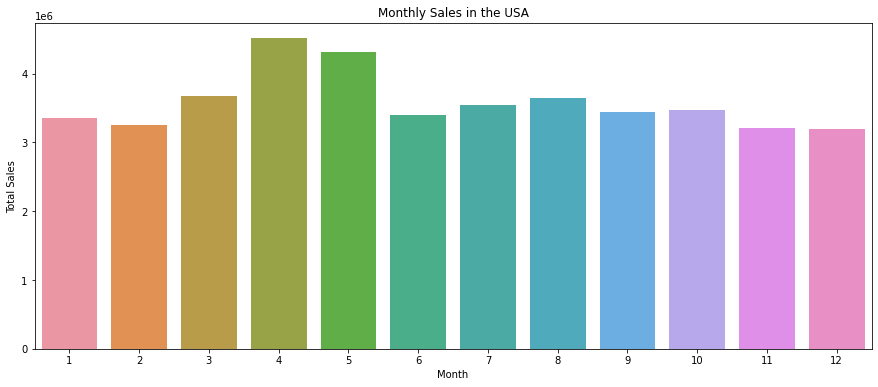

In [32]:
# 9. Sales based on the month in the USA
monthly_sales_usa = filtered_sales_data.groupby(['month'])['sales'].sum().reset_index()
plt.figure(figsize=(15, 6))
sns.barplot(x='month', y='sales', data=monthly_sales_usa)
plt.title('Monthly Sales in the USA')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()

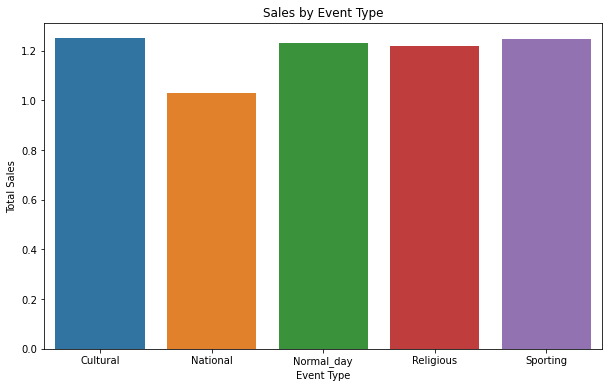

In [33]:
# 10. Sales based on event types
sales_by_event_type = filtered_sales_data.groupby(['event_type_1'])['sales'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='event_type_1', y='sales', data=sales_by_event_type)
plt.title('Sales by Event Type')
plt.xlabel('Event Type')
plt.ylabel('Total Sales')
plt.show()

/tmp/ipykernel_163572/1391029361.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sales_data['is_snap'] = filtered_sales_data['snap_CA'].apply(lambda x: 'SNAP' if x == 1 else 'No SNAP')


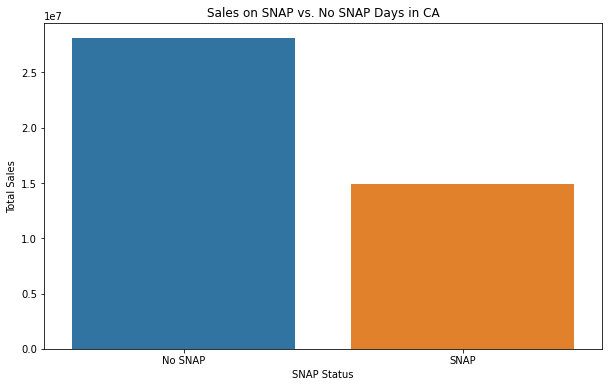

In [34]:
# 11. Total sale when day having snap and no snap
filtered_sales_data['is_snap'] = filtered_sales_data['snap_CA'].apply(lambda x: 'SNAP' if x == 1 else 'No SNAP')
sales_snap_vs_nosnap = filtered_sales_data.groupby('is_snap')['sales'].sum().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='is_snap', y='sales', data=sales_snap_vs_nosnap)
plt.title('Sales on SNAP vs. No SNAP Days in CA')
plt.xlabel('SNAP Status')
plt.ylabel('Total Sales')
plt.show()

/tmp/ipykernel_163572/642718749.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sales_data['date'] = pd.to_datetime(filtered_sales_data['date'])
/tmp/ipykernel_163572/642718749.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sales_data['weekday'] = filtered_sales_data['date'].dt.day_name()


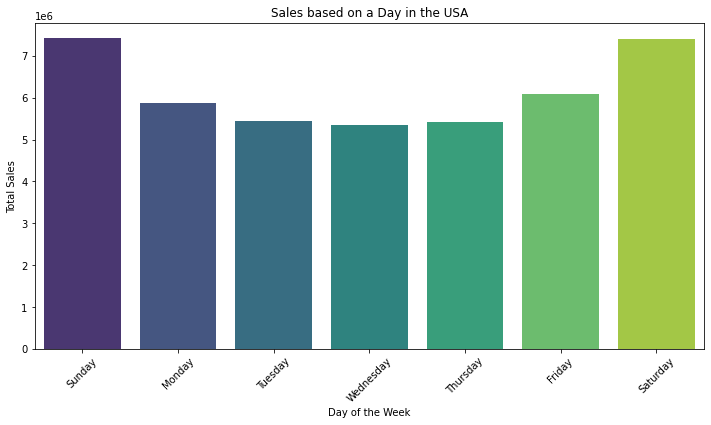

In [35]:
filtered_sales_data['date'] = pd.to_datetime(filtered_sales_data['date'])
# Extract the day of the week from the 'date' column
filtered_sales_data['weekday'] = filtered_sales_data['date'].dt.day_name()

# Aggregate sales by the day of the week
sales_by_weekday = filtered_sales_data.groupby('weekday')['sales'].sum().reset_index()

# Order the days of the week starting from Sunday for the plot
ordered_days = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
sales_by_weekday['weekday'] = pd.Categorical(sales_by_weekday['weekday'], categories=ordered_days, ordered=True)

# Sort the DataFrame by the ordered days
sales_by_weekday.sort_values('weekday', inplace=True)

# Plotting the sales by day of the week
plt.figure(figsize=(12, 6))
sns.barplot(x='weekday', y='sales', data=sales_by_weekday, palette="viridis")
plt.title('Sales based on a Day in the USA')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()


In [36]:
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.7 MB 6.6 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 16.8 MB 43.7 MB/s eta 0:00:01
  Created wheel for lightgbm: filename=lightgbm-4.3.0-py3-none-manylinux_2_17_x86_64.whl size=2787928 sha256=c3ec861d550bce43f766f2166d1bcdf79d202fa44dc546439aec985c8f7c0d89
  Stored in directory: /home/raj53/.cache/pip/wheels/fc/e6/da/850988b6c56b2650268501cd617c3512f709f05b57438d4628
Successfully built lightgbm
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: Could not install packages

In [37]:
# 1 Feature name: is_high_sale_months
# Assuming 'calendar' DataFrame is already loaded and contains a 'month' column

# Define a lambda function to check for months 3, 5, and 8
f = lambda x: 1 if x in [3, 5, 8] else 0

# Apply the lambda function to the 'month' column to create a new 'is_high_sale_months' column
sales_data_with_date['is_high_sale_months'] = sales_data_with_date['month'].apply(f)

# Display the updated 'calendar' DataFrame to verify the changes
print(sales_data_with_date[['month', 'is_high_sale_months']].head())  # Show the head of the DataFrame for quick verification
print(sales_data_with_date.shape)


   month  is_high_sale_months
0      3                    1
1      3                    1
2      3                    1
3      3                    1
4      3                    1
(35124480, 16)


In [38]:
# 2 Feature name: is_high_sale_day
# Convert 'date' column to datetime if it's not already
sales_data_with_date['date'] = pd.to_datetime(sales_data_with_date['date'])

# Create a new column 'day_of_week' to store the weekday name
sales_data_with_date['day_of_week'] = sales_data_with_date['date'].dt.day_name()

# Define a lambda function to check for high sale days (Friday, Saturday, Sunday)
f = lambda x: 1 if x in ["Friday", "Saturday", "Sunday"] else 0

# Apply the lambda function to the 'day_of_week' column to create a new 'is_high_sale_day' column
sales_data_with_date['is_high_sale_day'] = sales_data_with_date['day_of_week'].apply(f)

# Display the updated 'calendar' DataFrame to verify the changes
print(sales_data_with_date[['date', 'day_of_week', 'is_high_sale_day']].head(7))  # Show the head of the DataFrame for quick verification


        date day_of_week  is_high_sale_day
0 2013-03-28    Thursday                 0
1 2013-03-28    Thursday                 0
2 2013-03-28    Thursday                 0
3 2013-03-28    Thursday                 0
4 2013-03-28    Thursday                 0
5 2013-03-28    Thursday                 0
6 2013-03-28    Thursday                 0


In [39]:
# Assuming 'calendar' DataFrame is already loaded and contains an 'event_type_1' column

# Define a lambda function to check for "National" in the 'event_type_1' column
f = lambda x: 0 if x == "National" else 1

# Apply the lambda function to the 'event_type_1' column to create a new 'is_national_event' column
sales_data_with_date['is_national_event'] = sales_data_with_date['event_type_1'].apply(f)

# Display the updated 'calendar' DataFrame to verify the changes
print(sales_data_with_date[['event_type_1', 'is_national_event']].head(5))  # Show the head of the DataFrame for quick verification


  event_type_1  is_national_event
0   Normal_day                  1
1   Normal_day                  1
2   Normal_day                  1
3   Normal_day                  1
4   Normal_day                  1


In [40]:
# Feature name: is_christmas

# Define a lambda function to check for "Christmas" in the 'event_name_1' column
f = lambda x: 1 if x == 'Christmas' else 0

# Apply the lambda function to the 'event_name_1' column to create a new 'is_christmas' column
sales_data_with_date['is_christmas'] = sales_data_with_date['event_name_1'].map(f)

# Display the updated 'calendar' DataFrame to verify the changes
print(sales_data_with_date[['event_name_1', 'is_christmas']])

         event_name_1  is_christmas
0                 NaN             0
1                 NaN             0
2                 NaN             0
3                 NaN             0
4                 NaN             0
...               ...           ...
35124475          NaN             0
35124476          NaN             0
35124477          NaN             0
35124478          NaN             0
35124479          NaN             0

[35124480 rows x 2 columns]


In [41]:
import pandas as pd
import numpy as np

# Ensure 'date' is in datetime format
sales_data_with_date['date'] = pd.to_datetime(sales_data_with_date['date'])

# Sort the DataFrame to ensure rolling is done correctly
sales_data_with_date.sort_values(['item_id', 'store_id', 'date'], inplace=True)

# Create a unique identifier for each item-store combination
sales_data_with_date['item_store_id'] = sales_data_with_date['item_id'] + '_' + sales_data_with_date['store_id']

# Set the index to ['item_store_id', 'date'] for rolling operation
sales_data_with_date.set_index(['item_store_id', 'date'], inplace=True)

# Perform rolling operations
shifts = [28]
windows = [7, 14, 30, 60, 360]

for shift in shifts:
    for window in windows:
        for aggregate in ['mean', 'std']:
            # Define the column name for the new feature
            col_name = f'roll_{window}_shift_{shift}_{aggregate}'
            # Perform the rolling operation
            sales_data_with_date[col_name] = sales_data_with_date.groupby(level=0)['sales'].transform(lambda x: x.shift(shift).rolling(window).agg(aggregate))

# Reset the index after operations
sales_data_with_date.reset_index(inplace=True)

# Optionally, drop the 'item_store_id' if no longer needed
sales_data_with_date.drop('item_store_id', axis=1, inplace=True)

# Sort by 'id' or another column if needed to return to the original order
sales_data_with_date.sort_values('id', inplace=True)

# Display the DataFrame to verify the new features
print(sales_data_with_date.head())


          date                           id      item_id  dept_id cat_id  \
0   2013-03-28  FOODS_1_001_CA_1_evaluation  FOODS_1_001  FOODS_1  FOODS   
771 2015-05-08  FOODS_1_001_CA_1_evaluation  FOODS_1_001  FOODS_1  FOODS   
770 2015-05-07  FOODS_1_001_CA_1_evaluation  FOODS_1_001  FOODS_1  FOODS   
769 2015-05-06  FOODS_1_001_CA_1_evaluation  FOODS_1_001  FOODS_1  FOODS   
768 2015-05-05  FOODS_1_001_CA_1_evaluation  FOODS_1_001  FOODS_1  FOODS   

    store_id state_id       d  sales  wm_yr_wk  ... roll_7_shift_28_mean  \
0       CA_1       CA   d_790      1     11309  ...                  NaN   
771     CA_1       CA  d_1561      0     11514  ...             0.714286   
770     CA_1       CA  d_1560      0     11514  ...             0.714286   
769     CA_1       CA  d_1559      1     11514  ...             0.857143   
768     CA_1       CA  d_1558      0     11514  ...             0.714286   

    roll_7_shift_28_std  roll_14_shift_28_mean  roll_14_shift_28_std  \
0             

In [42]:
import pandas as pd
import numpy as np
import gc

# Assuming sales_data_with_date is already loaded

# Ensure 'date' is in datetime format
sales_data_with_date['date'] = pd.to_datetime(sales_data_with_date['date'])

# Sort the DataFrame to ensure the lag is applied correctly
sales_data_with_date.sort_values(['item_id', 'store_id', 'date'], inplace=True)

# Create lag features
lags = range(28, 100, 7)  # Define the range of lags

for lag in lags:
    # Define the column name for the new lag feature
    column_name = f'direct_lag_{lag}'
    # Shift the sales data by the specified lag to create the lag feature
    sales_data_with_date[column_name] = sales_data_with_date.groupby(['item_id', 'store_id'])['sales'].transform(lambda x: x.shift(lag)).fillna(-1).astype('int16')

# Clean up to free memory
gc.collect()
print(sales_data_with_date)


               date                               id          item_id  \
0        2013-03-28      FOODS_1_001_CA_1_evaluation      FOODS_1_001   
1        2013-03-29      FOODS_1_001_CA_1_evaluation      FOODS_1_001   
2        2013-03-30      FOODS_1_001_CA_1_evaluation      FOODS_1_001   
3        2013-03-31      FOODS_1_001_CA_1_evaluation      FOODS_1_001   
4        2013-04-01      FOODS_1_001_CA_1_evaluation      FOODS_1_001   
...             ...                              ...              ...   
35124475 2016-05-18  HOUSEHOLD_2_516_WI_3_evaluation  HOUSEHOLD_2_516   
35124476 2016-05-19  HOUSEHOLD_2_516_WI_3_evaluation  HOUSEHOLD_2_516   
35124477 2016-05-20  HOUSEHOLD_2_516_WI_3_evaluation  HOUSEHOLD_2_516   
35124478 2016-05-21  HOUSEHOLD_2_516_WI_3_evaluation  HOUSEHOLD_2_516   
35124479 2016-05-22  HOUSEHOLD_2_516_WI_3_evaluation  HOUSEHOLD_2_516   

              dept_id     cat_id store_id state_id       d  sales  wm_yr_wk  \
0             FOODS_1      FOODS     CA_1   

In [43]:
print(sales_data_with_date.dtypes)

date                      datetime64[ns]
id                                object
item_id                           object
dept_id                           object
cat_id                            object
store_id                          object
state_id                          object
d                                 object
sales                              int16
wm_yr_wk                           int16
event_name_1                      object
event_type_1                      object
snap_CA                            int16
month                              int64
year                               int64
is_high_sale_months                int64
day_of_week                       object
is_high_sale_day                   int64
is_national_event                  int64
is_christmas                       int64
roll_7_shift_28_mean             float64
roll_7_shift_28_std              float64
roll_14_shift_28_mean            float64
roll_14_shift_28_std             float64
roll_30_shift_28

In [44]:
print(sales_data_with_date.head())
print(sales_data_with_date.columns.tolist())

        date                           id      item_id  dept_id cat_id  \
0 2013-03-28  FOODS_1_001_CA_1_evaluation  FOODS_1_001  FOODS_1  FOODS   
1 2013-03-29  FOODS_1_001_CA_1_evaluation  FOODS_1_001  FOODS_1  FOODS   
2 2013-03-30  FOODS_1_001_CA_1_evaluation  FOODS_1_001  FOODS_1  FOODS   
3 2013-03-31  FOODS_1_001_CA_1_evaluation  FOODS_1_001  FOODS_1  FOODS   
4 2013-04-01  FOODS_1_001_CA_1_evaluation  FOODS_1_001  FOODS_1  FOODS   

  store_id state_id      d  sales  wm_yr_wk  ... direct_lag_35 direct_lag_42  \
0     CA_1       CA  d_790      1     11309  ...            -1            -1   
1     CA_1       CA  d_791      0     11309  ...            -1            -1   
2     CA_1       CA  d_792      1     11310  ...            -1            -1   
3     CA_1       CA  d_793      1     11310  ...            -1            -1   
4     CA_1       CA  d_794      1     11310  ...            -1            -1   

   direct_lag_49  direct_lag_56  direct_lag_63  direct_lag_70 direct_lag_7

In [45]:
# sales_data_with_date.head(100).to_csv('first_5_rows_sales_data_with_date.csv', index=False)

In [46]:
# Deleting the specified columns: 'roll_360_shift_28_mean' and 'roll_360_shift_28_std'
sales_data_with_date = sales_data_with_date.drop(['roll_360_shift_28_mean', 'roll_360_shift_28_std'], axis=1)

# Identifying roll shift and lag feature columns (assuming they contain 'roll_' or 'lag_' in their names)
roll_lag_columns = [col for col in sales_data_with_date.columns if 'roll_' in col or 'lag_' in col]

# For remaining columns that are roll shift or lag features, replace -1 values with the mean of that column
for col in roll_lag_columns:
    # Compute mean excluding the placeholder value (-1 for missing data)
    mean_value = sales_data_with_date[sales_data_with_date[col] != -1][col].mean()
    # Replace -1 with the computed mean value
    sales_data_with_date[col] = sales_data_with_date[col].replace(-1, mean_value)


# Display the first few rows to verify the changes
sales_data_with_date.head(100)

,date,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,wm_yr_wk,...,direct_lag_35,direct_lag_42,direct_lag_49,direct_lag_56,direct_lag_63,direct_lag_70,direct_lag_77,direct_lag_84,direct_lag_91,direct_lag_98
0,2013-03-28,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_790,1,11309,...,1.218636,1.217575,1.216062,1.215103,1.214256,1.213399,1.21219,1.210843,1.210287,1.208984
1,2013-03-29,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_791,0,11309,...,1.218636,1.217575,1.216062,1.215103,1.214256,1.213399,1.21219,1.210843,1.210287,1.208984
2,2013-03-30,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_792,1,11310,...,1.218636,1.217575,1.216062,1.215103,1.214256,1.213399,1.21219,1.210843,1.210287,1.208984
3,2013-03-31,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_793,1,11310,...,1.218636,1.217575,1.216062,1.215103,1.214256,1.213399,1.21219,1.210843,1.210287,1.208984
4,2013-04-01,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_794,1,11310,...,1.218636,1.217575,1.216062,1.215103,1.214256,1.213399,1.21219,1.210843,1.210287,1.208984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2013-07-01,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_885,1,11323,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.00000,2.000000,1.000000,1.208984
96,2013-07-02,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_886,0,11323,...,2.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,1.208984
97,2013-07-03,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_887,0,11323,...,2.000000,0.000000,3.000000,2.000000,2.000000,0.000000,0.00000,1.000000,0.000000,1.208984
98,2013-07-04,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_888,0,11323,...,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.00000,1.000000,1.000000,1.000000


In [47]:
# List of numeric columns with NaN values you want to replace with their mean
numeric_columns_with_nan = [
    'roll_7_shift_28_mean',
    'roll_7_shift_28_std',
    'roll_14_shift_28_mean',
    'roll_14_shift_28_std',
    'roll_30_shift_28_mean',
    'roll_30_shift_28_std',
    'roll_60_shift_28_mean',
    'roll_60_shift_28_std'
]

# Replace NaN with the mean of the column for each numeric column
for column in numeric_columns_with_nan:
    mean_value = sales_data_with_date[column].mean()
    sales_data_with_date[column].fillna(mean_value, inplace=True)


In [48]:
# Check for NaN values in the dataset
nan_counts = sales_data_with_date.isna().sum()
# Print columns with NaN values and their counts
print("Columns with NaN values and their counts:")
print(nan_counts[nan_counts > 0])
# Check total NaN values in the dataset
total_nan = sales_data_with_date.isna().sum().sum()
print(f"Total NaN values in the dataset: {total_nan}")

Columns with NaN values and their counts:
event_name_1    32319400
dtype: int64
Total NaN values in the dataset: 32319400


In [49]:

# manual_categorical_features = ['dept_id', 'cat_id', 'store_id', 'state_id','event_name_1','event_type_1','day_of_week']
# # categorical_features = list(set(auto_categorical_features + manual_categorical_features))

# # Ensure only relevant features are included
# # categorical_features = [cf for cf in manual_categorical_features if cf not in ['id', 'sales', 'date', 'd']]

# # Define target and features
# X = sales_data_with_date.drop(['id', 'sales', 'date', 'd','item_id'], axis=1)
# y = sales_data_with_date['sales']

# # Define preprocessor
# preprocessor = ColumnTransformer(transformers=[
#     ('cat', OneHotEncoder(handle_unknown='ignore'), manual_categorical_features)],
#     remainder='passthrough')

# # Define model pipelines
# pipelines = {
#     'Lasso': Pipeline([
#         ('preprocessor', preprocessor),
#         ('scaler', StandardScaler(with_mean=False)),
#         ('model', Lasso(alpha=0.1))
#     ]),
#     'Ridge': Pipeline([
#         ('preprocessor', preprocessor),
#         ('scaler', StandardScaler(with_mean=False)),
#         ('model', Ridge(alpha=0.1))
#     ])
# }

# # Manually split data into training and testing sets
# # All data except last 28 rows for training
# X_train = X.iloc[:-56]
# y_train = y.iloc[:-56]

# # Last 28 rows for testing
# X_test = X.iloc[-56:-28]
# y_test = y.iloc[-56:-28]

# # Fit models and calculate RMSE
# for name, pipeline in pipelines.items():
#     pipeline.fit(X_train, y_train)
#     y_pred = pipeline.predict(X_test)
#     rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#     print(f'{name} RMSE: {rmse}')


In [50]:
def categorize_row(d_value):
    if 'd_1520' <= d_value <= 'd_1885':
        return 'train'
    elif 'd_1886' <= d_value <= 'd_1913':
        return 'test'
    elif d_value > 'd_1913':
        return 'predict'
    else:
        return 'exclude'  # For any rows that don't match the criteria

# Apply the function to the 'd' column to create a new 'phase' column
sales_data_with_date['phase'] = sales_data_with_date['d'].apply(categorize_row)

# Now, your DataFrame has a 'phase' column identifying each row as 'train', 'test', or 'predict'

In [51]:
dtype = {
    'id': 'object',
    'item_id': 'int64',
    'dept_id': 'int8',
    'cat_id': 'int8',
    'store_id': 'int8',
    'state_id': 'int8',
    'd': 'object',
    'sales': 'int16',
    'date': 'object',
    'wday': 'int8',
    'month': 'int8',
    'year': 'int16',
    'event_name_1': 'int8',
    'event_type_1': 'int8',
    'event_name_2': 'int8',
    'event_type_2': 'int8',
    'snap': 'int8',
    'sell_price': 'float16',
    'price_change': 'float16',
    'week_number': 'int8',
    'season': 'object',
    'quater_start': 'int8',
    'quater_end': 'int8',
    'month_start': 'int8',
    'month_end': 'int8',
    'year_start': 'int8',
    'year_end': 'int8',
    'group': 'int8',
    'no_events': 'object',
    'holiday': 'object',
    'roll_7_shift_28_mean': 'float16',
    'roll_14_shift_28_mean': 'float16',
    'roll_30_shift_28_mean': 'float16',
    'roll_60_shift_28_mean': 'float16',
    'roll_360_shift_28_mean': 'float16',
    'roll_7_shift_28_std': 'float16',
    'roll_14_shift_28_std': 'float16',
    'roll_30_shift_28_std': 'float16',
    'roll_60_shift_28_std': 'float16',
    'roll_360_shift_28_std': 'float16',
    'direct_ewm': 'float16',
    'direct_lag_28': 'int16',
    'direct_lag_35': 'int16',
    'direct_lag_42': 'int16',
    'direct_lag_49': 'int16',
    'direct_lag_56': 'int16',
    'direct_lag_63': 'int16',
    'direct_lag_70': 'int16',
    'direct_lag_77': 'int16',
    'direct_lag_84': 'int16',
    'direct_lag_91': 'int16',
    'direct_lag_98': 'int16',
    'min_price': 'float16',
    'max_price': 'float16',
    'mean_price': 'float16',
    'std_price': 'float16',
    'price_norm_1': 'float16',
    'price_norm_2': 'float16',
    'price_norm_3': 'float16'
}


In [52]:
sales_data_with_date = sales_data_with_date[sales_data_with_date['cat_id'] == 'FOODS']

In [53]:
# Export the top 100 rows of the DataFrame to a CSV file
sales_data_with_date.head(100).to_csv('top_100_rows_sales_data_with_date.csv', index=False)

In [54]:
# import numpy as np
# import pandas as pd
# import tensorflow as tf
# from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.metrics import mean_squared_error
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Flatten, concatenate, Reshape
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.regularizers import l2

# # Assuming 'sales_data_with_date' is your DataFrame and is already loaded

# # Encode 'item_id' as integers for the embedding layer
# item_id_encoder = LabelEncoder()
# sales_data_with_date['item_id_encoded'] = item_id_encoder.fit_transform(sales_data_with_date['item_id'])

# # Max value for item_id_encoded, to set the input_dim in the Embedding layer
# max_item_id = sales_data_with_date['item_id_encoded'].max()

# # Define numeric and categorical features excluding 'item_id'
# numeric_features = ['snap_CA', 'month', 'is_high_sale_months', 'is_high_sale_day', 'is_national_event', 'is_christmas',
#                     'roll_7_shift_28_mean', 'roll_7_shift_28_std', 'roll_14_shift_28_mean', 'roll_14_shift_28_std',
#                     'roll_30_shift_28_mean', 'roll_30_shift_28_std', 'roll_60_shift_28_mean', 'roll_60_shift_28_std',
#                     'direct_lag_28', 'direct_lag_35', 'direct_lag_42', 'direct_lag_49', 'direct_lag_56', 'direct_lag_63',
#                     'direct_lag_70', 'direct_lag_77', 'direct_lag_84', 'direct_lag_91', 'direct_lag_98']
# categorical_features = ['dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'day_of_week']

# # Filter the DataFrame based on 'phase' column for training and testing
# train_data = sales_data_with_date[sales_data_with_date['phase'] == 'train']
# test_data = sales_data_with_date[sales_data_with_date['phase'] == 'test']

# # Prepare inputs, keeping 'item_id_encoded' for embedding
# X_train = train_data.drop(columns=['id', 'sales', 'date', 'd', 'phase', 'item_id'])
# X_test = test_data.drop(columns=['id', 'sales', 'date', 'd', 'phase', 'item_id'])

# item_id_train = train_data['item_id_encoded'].values
# item_id_test = test_data['item_id_encoded'].values

# y_train = train_data['sales']
# y_test = test_data['sales']

# # Preprocess the features
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', MinMaxScaler(), numeric_features),
#         ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
#     ]
# )

# X_train_processed = preprocessor.fit_transform(X_train)
# X_test_processed = preprocessor.transform(X_test)

# # Ensure processed data is a numpy array
# X_train_processed = np.array(X_train_processed)
# X_test_processed = np.array(X_test_processed)

# # Model inputs
# num_cat_input = Input(shape=(X_train_processed.shape[1],), name='num_cat_input')
# item_id_input = Input(shape=(1,), name='item_id_input')

# # Embedding for item_id
# embedding_size = 50  # Example size, may require tuning
# item_id_embedding = Embedding(input_dim=max_item_id + 1, output_dim=embedding_size, input_length=1, name='item_id_embedding')(item_id_input)
# item_id_embedding = Flatten()(item_id_embedding)

# # Combine inputs
# combined_input = concatenate([num_cat_input, item_id_embedding])

# # Add a Reshape layer to introduce a time step dimension
# combined_input_reshaped = Reshape((1, combined_input.shape[1]))(combined_input)

# # LSTM layer
# lstm_out = LSTM(32, activation='relu', kernel_regularizer=l2(0.0001))(combined_input_reshaped)
# dropout_out = Dropout(0.4)(lstm_out)
# output = Dense(1)(dropout_out)

# # Build and compile the model
# model = Model(inputs=[num_cat_input, item_id_input], outputs=output)
# optimizer = Adam(learning_rate=0.0005)
# model.compile(optimizer=optimizer, loss='mse')

# # Fit the model
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001)
# model.fit([X_train_processed, item_id_train], y_train.values, epochs=2, batch_size=64, validation_data=([X_test_processed, item_id_test], y_test.values), verbose=2, callbacks=[early_stopping, reduce_lr])

# # Prediction and RMSE calculation
# y_pred = model.predict([X_test_processed, item_id_test])
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# print(f'Optimized LSTM RMSE: {rmse}')

In [55]:
# import numpy as np
# import pandas as pd
# import tensorflow as tf
# from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.metrics import mean_squared_error
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, Flatten, concatenate
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.regularizers import l2

# # Assuming 'sales_data_with_date' is your DataFrame and is already loaded

# # Encode 'item_id' as integers for the embedding layer
# item_id_encoder = LabelEncoder()
# sales_data_with_date['item_id_encoded'] = item_id_encoder.fit_transform(sales_data_with_date['item_id'])

# # Max value for item_id_encoded, to set the input_dim in the Embedding layer
# max_item_id = sales_data_with_date['item_id_encoded'].max()

# # Define numeric and categorical features excluding 'item_id'
# numeric_features = ['snap_CA', 'month', 'is_high_sale_months', 'is_high_sale_day', 'is_national_event', 'is_christmas']
# categorical_features = ['dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'day_of_week']

# # Simplify by using fewer features if memory issues persist

# # Filter the DataFrame for training and testing
# train_data = sales_data_with_date[sales_data_with_date['phase'] == 'train']
# test_data = sales_data_with_date[sales_data_with_date['phase'] == 'test']

# # Prepare inputs
# X_train = train_data.drop(columns=['id', 'sales', 'date', 'd', 'phase', 'item_id'])
# X_test = test_data.drop(columns=['id', 'sales', 'date', 'd', 'phase', 'item_id'])

# item_id_train = train_data['item_id_encoded'].values
# item_id_test = test_data['item_id_encoded'].values

# y_train = train_data['sales']
# y_test = test_data['sales']

# # Preprocess the features
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', MinMaxScaler(), numeric_features),
#         ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), categorical_features)  # Ensure output is dense
#     ]
# )

# X_train_processed = preprocessor.fit_transform(X_train)
# X_test_processed = preprocessor.transform(X_test)

# # Model inputs
# num_cat_input = Input(shape=(X_train_processed.shape[1],), name='num_cat_input')
# item_id_input = Input(shape=(1,), name='item_id_input')

# # Embedding for item_id
# embedding_size = 20  # Reduced size for memory efficiency
# item_id_embedding = Embedding(input_dim=max_item_id + 1, output_dim=embedding_size, input_length=1, name='item_id_embedding')(item_id_input)
# item_id_embedding = Flatten()(item_id_embedding)

# # Combine inputs
# combined_input = concatenate([num_cat_input, item_id_embedding])

# # Simplified model without LSTM for memory efficiency
# dense_out = Dense(64, activation='relu', kernel_regularizer=l2(0.0001))(combined_input)
# dropout_out = Dropout(0.3)(dense_out)
# output = Dense(1)(dropout_out)

# # Build and compile the model
# model = Model(inputs=[num_cat_input, item_id_input], outputs=output)
# optimizer = Adam(learning_rate=0.001)
# model.compile(optimizer=optimizer, loss='mse')

# # Fit the model with smaller batch size
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
# model.fit([X_train_processed, item_id_train], y_train.values, epochs=5, batch_size=32, validation_data=([X_test_processed, item_id_test], y_test.values), verbose=2, callbacks=[early_stopping, reduce_lr])

# # Prediction and evaluation
# y_pred = model.predict([X_test_processed, item_id_test])
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# print(f'Simplified Model RMSE: {rmse}')


In [56]:
# Ensure 'date' is in datetime format
sales_data_with_date['date'] = pd.to_datetime(sales_data_with_date['date'])

# Set the date as the DataFrame index for time series operations
sales_data_with_date.set_index('date', inplace=True)

# Creating lagged sales features for the same day in the previous year
sales_data_with_date['sales_lag_365'] = sales_data_with_date.groupby(['item_id', 'store_id'])['sales'].transform(lambda x: x.shift(365))

# Creating a feature for sales differences between consecutive days
sales_data_with_date['sales_diff'] = sales_data_with_date.groupby(['item_id', 'store_id'])['sales'].transform(lambda x: x.diff())

# Reset the index after the transformations
sales_data_with_date.reset_index(inplace=True)

In [72]:
sales_data_with_date['sales_diff'].tail(100)

16554140   -1.0
16554141   -1.0
16554142    1.0
16554143   -1.0
16554144    0.0
           ... 
16554235   -4.0
16554236    2.0
16554237    0.0
16554238    3.0
16554239   -4.0
Name: sales_diff, Length: 100, dtype: float32

In [57]:
#Previous code with rmse 2.82
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Flatten, concatenate, Reshape, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Assuming 'sales_data_with_date' is your DataFrame and is already loaded

# Encode 'item_id' as integers for the embedding layer
item_id_encoder = LabelEncoder()
sales_data_with_date['item_id_encoded'] = item_id_encoder.fit_transform(sales_data_with_date['item_id'])

# Max value for item_id_encoded, to set the input_dim in the Embedding layer
max_item_id = sales_data_with_date['item_id_encoded'].max()

# Define numeric and categorical features excluding 'item_id'
numeric_features = ['snap_CA', 'month', 'is_high_sale_months', 'is_high_sale_day', 'is_national_event', 'is_christmas',
                    'roll_7_shift_28_mean', 'roll_7_shift_28_std', 'roll_14_shift_28_mean', 'roll_14_shift_28_std',
                    'roll_30_shift_28_mean', 'roll_30_shift_28_std', 'roll_60_shift_28_mean', 'roll_60_shift_28_std',
                    'direct_lag_28', 'direct_lag_35', 'direct_lag_42', 'direct_lag_49', 'direct_lag_56', 'direct_lag_63',
                    'direct_lag_70', 'direct_lag_77', 'direct_lag_84', 'direct_lag_91', 'direct_lag_98', 'sales_lag_365', 'sales_diff']
categorical_features = ['dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'day_of_week']

# Filter the DataFrame based on 'phase' column for training and testing
train_data = sales_data_with_date[sales_data_with_date['phase'] == 'train']
test_data = sales_data_with_date[sales_data_with_date['phase'] == 'test']

# Prepare inputs, keeping 'item_id_encoded' for embedding
X_train = train_data.drop(columns=['id', 'sales', 'date', 'd', 'phase', 'item_id'])
X_test = test_data.drop(columns=['id', 'sales', 'date', 'd', 'phase', 'item_id'])

item_id_train = train_data['item_id_encoded'].values
item_id_test = test_data['item_id_encoded'].values

y_train = train_data['sales']
y_test = test_data['sales']

# Preprocess the features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Ensure processed data is a numpy array
X_train_processed = np.array(X_train_processed)
X_test_processed = np.array(X_test_processed)

# Model inputs
num_cat_input = Input(shape=(X_train_processed.shape[1],), name='num_cat_input')
item_id_input = Input(shape=(1,), name='item_id_input')

# Embedding for item_id
embedding_size = 50
item_id_embedding = Embedding(input_dim=max_item_id + 1, output_dim=embedding_size, input_length=1, name='item_id_embedding')(item_id_input)
item_id_embedding = Flatten()(item_id_embedding)

combined_input = concatenate([num_cat_input, item_id_embedding])
combined_input_reshaped = Reshape((1, combined_input.shape[1]))(combined_input)

# Using a Bidirectional LSTM
lstm_out = Bidirectional(LSTM(64, return_sequences=True, activation='relu', kernel_regularizer=l2(0.001)))(combined_input_reshaped)
lstm_out = Bidirectional(LSTM(32, activation='relu', kernel_regularizer=l2(0.001)))(lstm_out)

dropout_out = Dropout(0.5)(lstm_out)
batch_norm_out = BatchNormalization()(dropout_out)
output = Dense(1)(batch_norm_out)

model = Model(inputs=[num_cat_input, item_id_input], outputs=output)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Fit the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
model.fit([X_train_processed, item_id_train], y_train.values, epochs=10, batch_size=128, validation_data=([X_test_processed, item_id_test], y_test.values), verbose=2, callbacks=[early_stopping, reduce_lr])

# Prediction and RMSE calculation
y_pred = model.predict([X_test_processed, item_id_test])
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Optimized LSTM RMSE: {rmse}')

2024-02-20 01:37:39.886866: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 01:37:39.886907: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 01:37:39.888242: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-20 01:37:39.896886: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-20 01:37:41.019725: W tensorflow/comp

Epoch 1/10
41090/41090 - 173s - loss: 8.0586 - val_loss: 5.1475 - lr: 0.0010 - 173s/epoch - 4ms/step
Epoch 2/10
41090/41090 - 169s - loss: 6.2749 - val_loss: 4.6780 - lr: 0.0010 - 169s/epoch - 4ms/step
Epoch 3/10
41090/41090 - 169s - loss: 5.9407 - val_loss: 5.6051 - lr: 0.0010 - 169s/epoch - 4ms/step
Epoch 4/10
41090/41090 - 169s - loss: 5.7746 - val_loss: 4.8011 - lr: 0.0010 - 169s/epoch - 4ms/step
Epoch 5/10
41090/41090 - 169s - loss: 5.7121 - val_loss: 4.6432 - lr: 0.0010 - 169s/epoch - 4ms/step
Epoch 6/10
41090/41090 - 169s - loss: 5.6109 - val_loss: 4.5404 - lr: 0.0010 - 169s/epoch - 4ms/step
Epoch 7/10
41090/41090 - 169s - loss: 5.5405 - val_loss: 4.3362 - lr: 0.0010 - 169s/epoch - 4ms/step
Epoch 8/10
41090/41090 - 170s - loss: 5.4909 - val_loss: 4.5456 - lr: 0.0010 - 170s/epoch - 4ms/step
Epoch 9/10
41090/41090 - 170s - loss: 5.4517 - val_loss: 4.3855 - lr: 0.0010 - 170s/epoch - 4ms/step
Epoch 10/10
41090/41090 - 170s - loss: 5.4387 - val_loss: 4.3826 - lr: 0.0010 - 170s/epoch 

In [59]:
from sklearn.metrics import mean_absolute_error

# Assuming y_test and y_pred are already defined based on your model's predictions
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')


Mean Absolute Error (MAE): 1.0722594261169434


In [104]:
pip install --upgrade lightgbm


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [108]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import numpy as np

# Loop over each categorical column and convert it to 'category' type using .loc for both train and test data
for col in categorical_features:
    train_data.loc[:, col] = train_data.loc[:, col].astype('category')
    test_data.loc[:, col] = test_data.loc[:, col].astype('category')

# Prepare datasets
lgb_train = lgb.Dataset(data=X_train_processed, label=y_train)
lgb_eval = lgb.Dataset(data=X_test_processed, label=y_test, reference=lgb_train)

# Parameters
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
}

# Train the model without early stopping
num_boost_round = 100
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=num_boost_round,
                valid_sets=lgb_eval)

# Predict
y_pred_gbm = gbm.predict(X_test_processed, num_iteration=num_boost_round)
rmse_gbm = np.sqrt(mean_squared_error(y_test, y_pred_gbm))
print(f'LightGBM RMSE: {rmse_gbm}')


/apps/cent7/jupyterhub/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.164440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3476
[LightGBM] [Info] Number of data points in the train set: 5259420, number of used features: 87
[LightGBM] [Info] Start training from score 1.778423
LightGBM RMSE: 1.9060382441219677


In [110]:


# MAE Calculation
mae_gbm = mean_absolute_error(y_test, y_pred_gbm)
print(f'LightGBM MAE: {mae_gbm}')


LightGBM MAE: 0.8731982010778248


In [112]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
     |█████████████████████████████▌  | 274.0 MB 108.0 MB/s eta 0:00:01     |███████████████████████████▊    | 257.2 MB 108.0 MB/s eta 0:00:01

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [114]:
import xgboost as xgb

# Prepare datasets
dtrain = xgb.DMatrix(X_train_processed, label=y_train)
dtest = xgb.DMatrix(X_test_processed, label=y_test)

# Parameters
param = {
    'max_depth': 5,
    'eta': 0.1,
    'objective': 'reg:squarederror',
}
num_round = 200

# Train the model
bst = xgb.train(param, dtrain, num_round)

# Predict
y_pred_xgb = bst.predict(dtest)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f'XGBoost RMSE: {rmse_xgb}')


XGBoost RMSE: 1.9661860466003418


In [116]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming the previous XGBoost training and prediction code



# MAE Calculation
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f'XGBoost MAE: {mae_xgb}')


XGBoost MAE: 0.8622968792915344


In [118]:
# Ridge
ridge = Ridge(alpha=0.1)
ridge.fit(X_train_processed, y_train)
y_pred_ridge = ridge.predict(X_test_processed)
print("Ridge MAE:", mean_absolute_error(y_test, y_pred_ridge))

Ridge MAE: 1.1363832699764058


In [60]:
# Selecting the 'predict' phase data
predict_data = sales_data_with_date[sales_data_with_date['phase'] == 'predict']
# Prepare the feature matrix for prediction, excluding columns not used in model training
X_predict = predict_data.drop(columns=['id', 'sales', 'date', 'd', 'phase', 'item_id'])

# Assuming you've encoded 'item_id' for embedding in your model
item_id_predict = predict_data['item_id_encoded'].values

# Use the preprocessor fitted on the training data to transform features of the predict dataset
X_predict_processed = preprocessor.transform(X_predict)
X_predict_processed = np.array(X_predict_processed)
# Generate predictions using the model
y_predict = model.predict([X_predict_processed, item_id_predict])

# Optionally, print or further process the predictions as needed
print(y_predict)


106877/106877 [==============================] - 174s 2ms/step
[[       nan]
 [       nan]
 [       nan]
 ...
 [0.84462833]
 [5.018386  ]
 [0.6190593 ]]


In [73]:
y_predict.shape

(3420060, 1)

In [67]:
filtered_data = sales_data_with_date[(sales_data_with_date['cat_id'] == "FOODS") & (sales_data_with_date['phase'] == "predict")]
num_rows = len(filtered_data)

print(f"Number of rows where cat_id is 'FOODS' and phase is 'Predict': {num_rows}")

Number of rows where cat_id is 'FOODS' and phase is 'Predict': 3420060


In [68]:
Predicted_data = sales_data_with_date[sales_data_with_date['phase'] == 'predict']

In [69]:
Predicted_data.shape

(3420060, 43)

In [75]:
import pandas as pd

# Assuming Predicted_data is a DataFrame and y_predict is a numpy array

# Reset the index of Predicted_data DataFrame to ensure alignment
Predicted_data_reset = Predicted_data.reset_index(drop=True)

# Convert y_predict numpy array to a pandas DataFrame
y_predict_df = pd.DataFrame(y_predict, columns=['Predicted_Values'])

# Concatenate the DataFrames side by side
predict_combined_1 = pd.concat([Predicted_data_reset, y_predict_df], axis=1)

# Print the result
print(predict_combined_1)


              date                           id      item_id  dept_id cat_id  \
0       2013-03-28  FOODS_1_001_CA_1_evaluation  FOODS_1_001  FOODS_1  FOODS   
1       2013-03-29  FOODS_1_001_CA_1_evaluation  FOODS_1_001  FOODS_1  FOODS   
2       2013-03-30  FOODS_1_001_CA_1_evaluation  FOODS_1_001  FOODS_1  FOODS   
3       2013-03-31  FOODS_1_001_CA_1_evaluation  FOODS_1_001  FOODS_1  FOODS   
4       2013-04-01  FOODS_1_001_CA_1_evaluation  FOODS_1_001  FOODS_1  FOODS   
...            ...                          ...          ...      ...    ...   
3420055 2016-05-18  FOODS_3_827_WI_3_evaluation  FOODS_3_827  FOODS_3  FOODS   
3420056 2016-05-19  FOODS_3_827_WI_3_evaluation  FOODS_3_827  FOODS_3  FOODS   
3420057 2016-05-20  FOODS_3_827_WI_3_evaluation  FOODS_3_827  FOODS_3  FOODS   
3420058 2016-05-21  FOODS_3_827_WI_3_evaluation  FOODS_3_827  FOODS_3  FOODS   
3420059 2016-05-22  FOODS_3_827_WI_3_evaluation  FOODS_3_827  FOODS_3  FOODS   

        store_id state_id       d  sale

In [76]:
print(y_predict.shape)

(3420060, 1)


In [86]:
foods_data = sales_data_with_date[sales_data_with_date['item_id'] == 'FOODS_1_001']

# Group by 'date' and count the number of rows for each day
rows_count_per_day = foods_data.groupby('date').size()

# Display the result
print(rows_count_per_day)

date
2013-03-28    10
2013-03-29    10
2013-03-30    10
2013-03-31    10
2013-04-01    10
              ..
2016-05-18    10
2016-05-19    10
2016-05-20    10
2016-05-21    10
2016-05-22    10
Length: 1152, dtype: int64


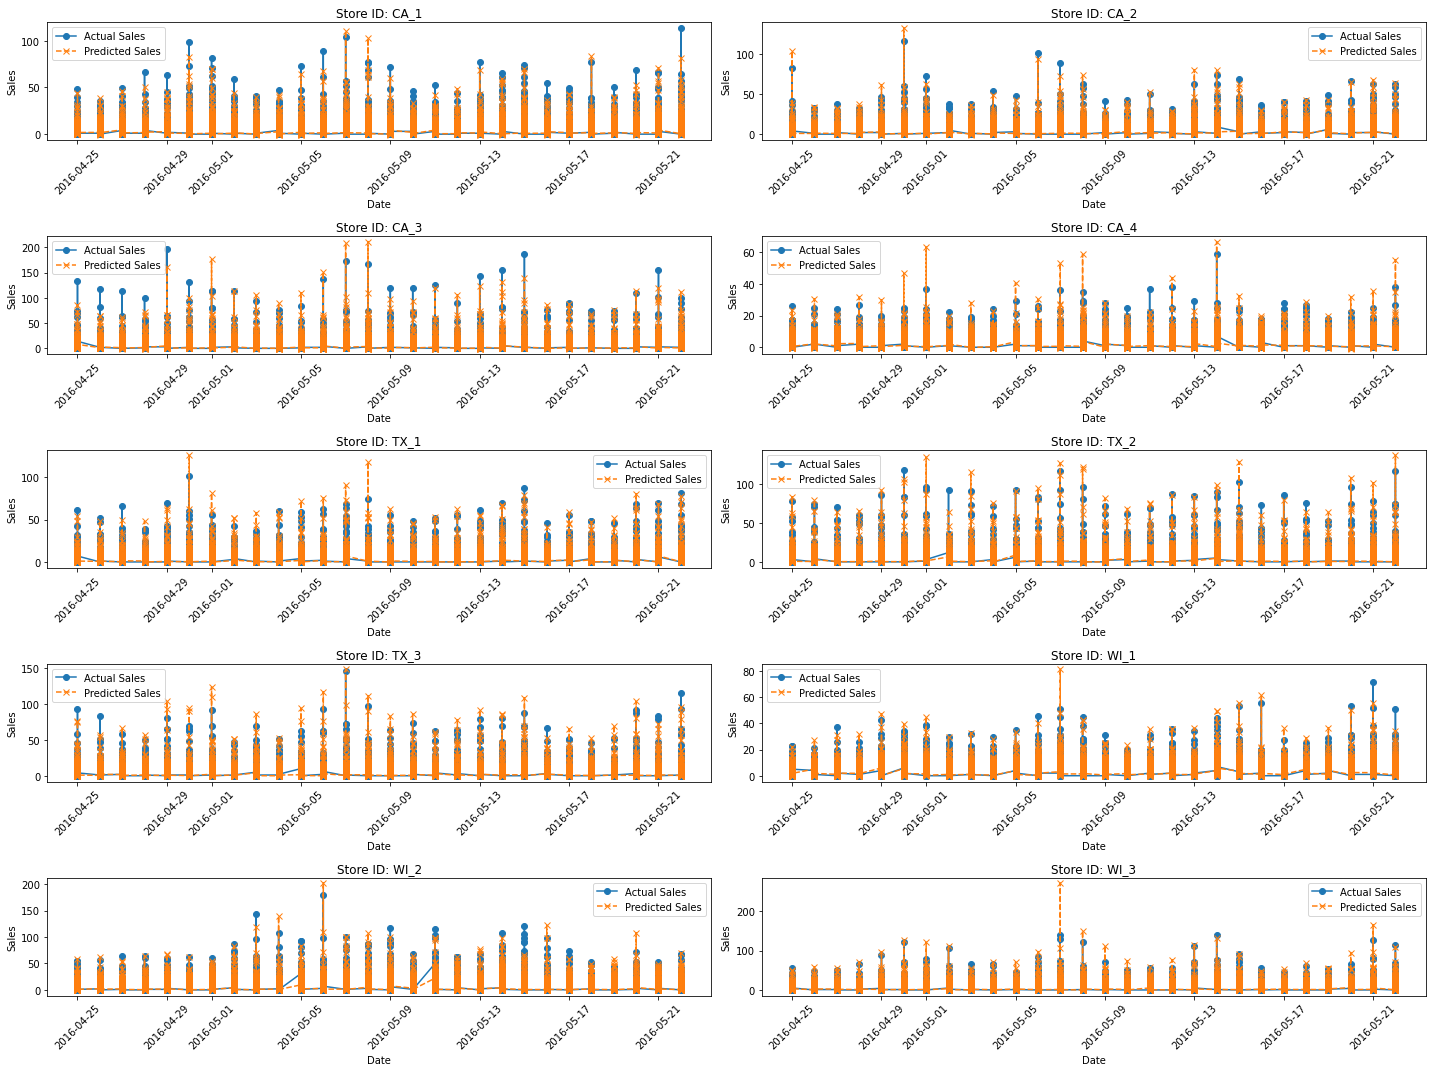

In [92]:
import matplotlib.pyplot as plt

# Assuming predict_combined_1 is your DataFrame with actual and predicted sales
# And it contains columns 'store_id', 'date', 'sales', and 'Predicted_Values'

# Select the unique store_ids for plotting
unique_store_ids = predict_combined_1['store_id'].unique()[:10]  # Adjust the number as needed

# Set up the figure size and layout
plt.figure(figsize=(20, 15))

# Iterate over each store_id to create a separate plot
for i, store_id in enumerate(unique_store_ids, start=1):
    # Filter the DataFrame for the current store_id
    data = predict_combined_1[predict_combined_1['store_id'] == store_id]

    # Ensure data is sorted by date
    data = data.sort_values('date')
    
    # Filter out rows where 'Predicted_Values' is NaN or any specific placeholder for missing predictions (if applicable)
    data = data.dropna(subset=['Predicted_Values'])
    # Optional: if you use a placeholder like -1 for missing predictions, uncomment the next line
    # data = data[data['Predicted_Values'] != -1]

    # Proceed with plotting only if there are rows with valid predicted values
    if not data.empty:
        # Create a subplot for the current store_id
        plt.subplot(5, 2, i)  # Adjust the grid dimensions as needed
        plt.plot(data['date'], data['sales'], marker='o', label='Actual Sales')
        plt.plot(data['date'], data['Predicted_Values'], marker='x', linestyle='--', label='Predicted Sales')

        # Add titles and labels
        plt.title(f'Store ID: {store_id}')
        plt.xlabel('Date')
        plt.ylabel('Sales')
        plt.legend()
        plt.xticks(rotation=45)  # Rotate date labels for better readability
        plt.tight_layout()

plt.show()


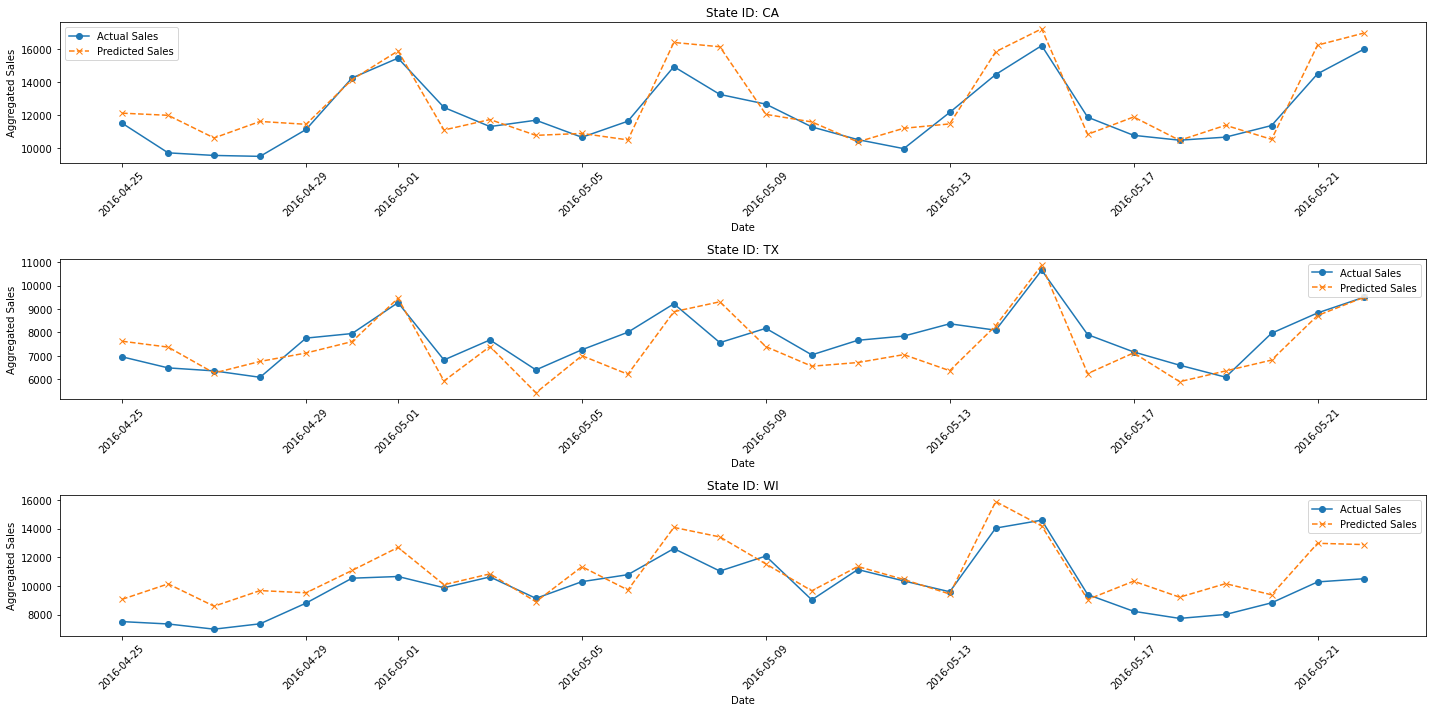

In [98]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming predict_combined_1 is your DataFrame with actual and predicted sales
# And it contains columns 'state_id', 'date', 'sales', and 'predicted_sales'

# Aggregate sales by state_id and date
state_sales_agg = predict_combined_1.groupby(['state_id', 'date']).agg({
    'sales': 'sum',
    # Sum predicted_sales but ignore NaN values. Adjust if your data uses another indicator for missing predictions.
    'Predicted_Values': lambda x: x.dropna().sum()
}).reset_index()

# Filter out rows where predicted_sales might be zero or NaN after aggregation
state_sales_agg = state_sales_agg[state_sales_agg['Predicted_Values'] > 0]

# Select unique state_ids (assuming you want to plot for all, adjust as necessary)
unique_state_ids = state_sales_agg['state_id'].unique()

# Plotting
plt.figure(figsize=(20, 10))

for i, state_id in enumerate(unique_state_ids, start=1):
    data = state_sales_agg[state_sales_agg['state_id'] == state_id]

    plt.subplot(len(unique_state_ids), 1, i)  # Adjust subplot layout as needed
    plt.plot(data['date'], data['sales'], 'o-', label='Actual Sales')
    # Ensure predicted_sales values are plotted only if they exist.
    if not data['Predicted_Values'].isnull().all():
        plt.plot(data['date'], data['Predicted_Values'], 'x--', label='Predicted Sales')
    plt.title(f'State ID: {state_id}')
    plt.xlabel('Date')
    plt.ylabel('Aggregated Sales')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.show()


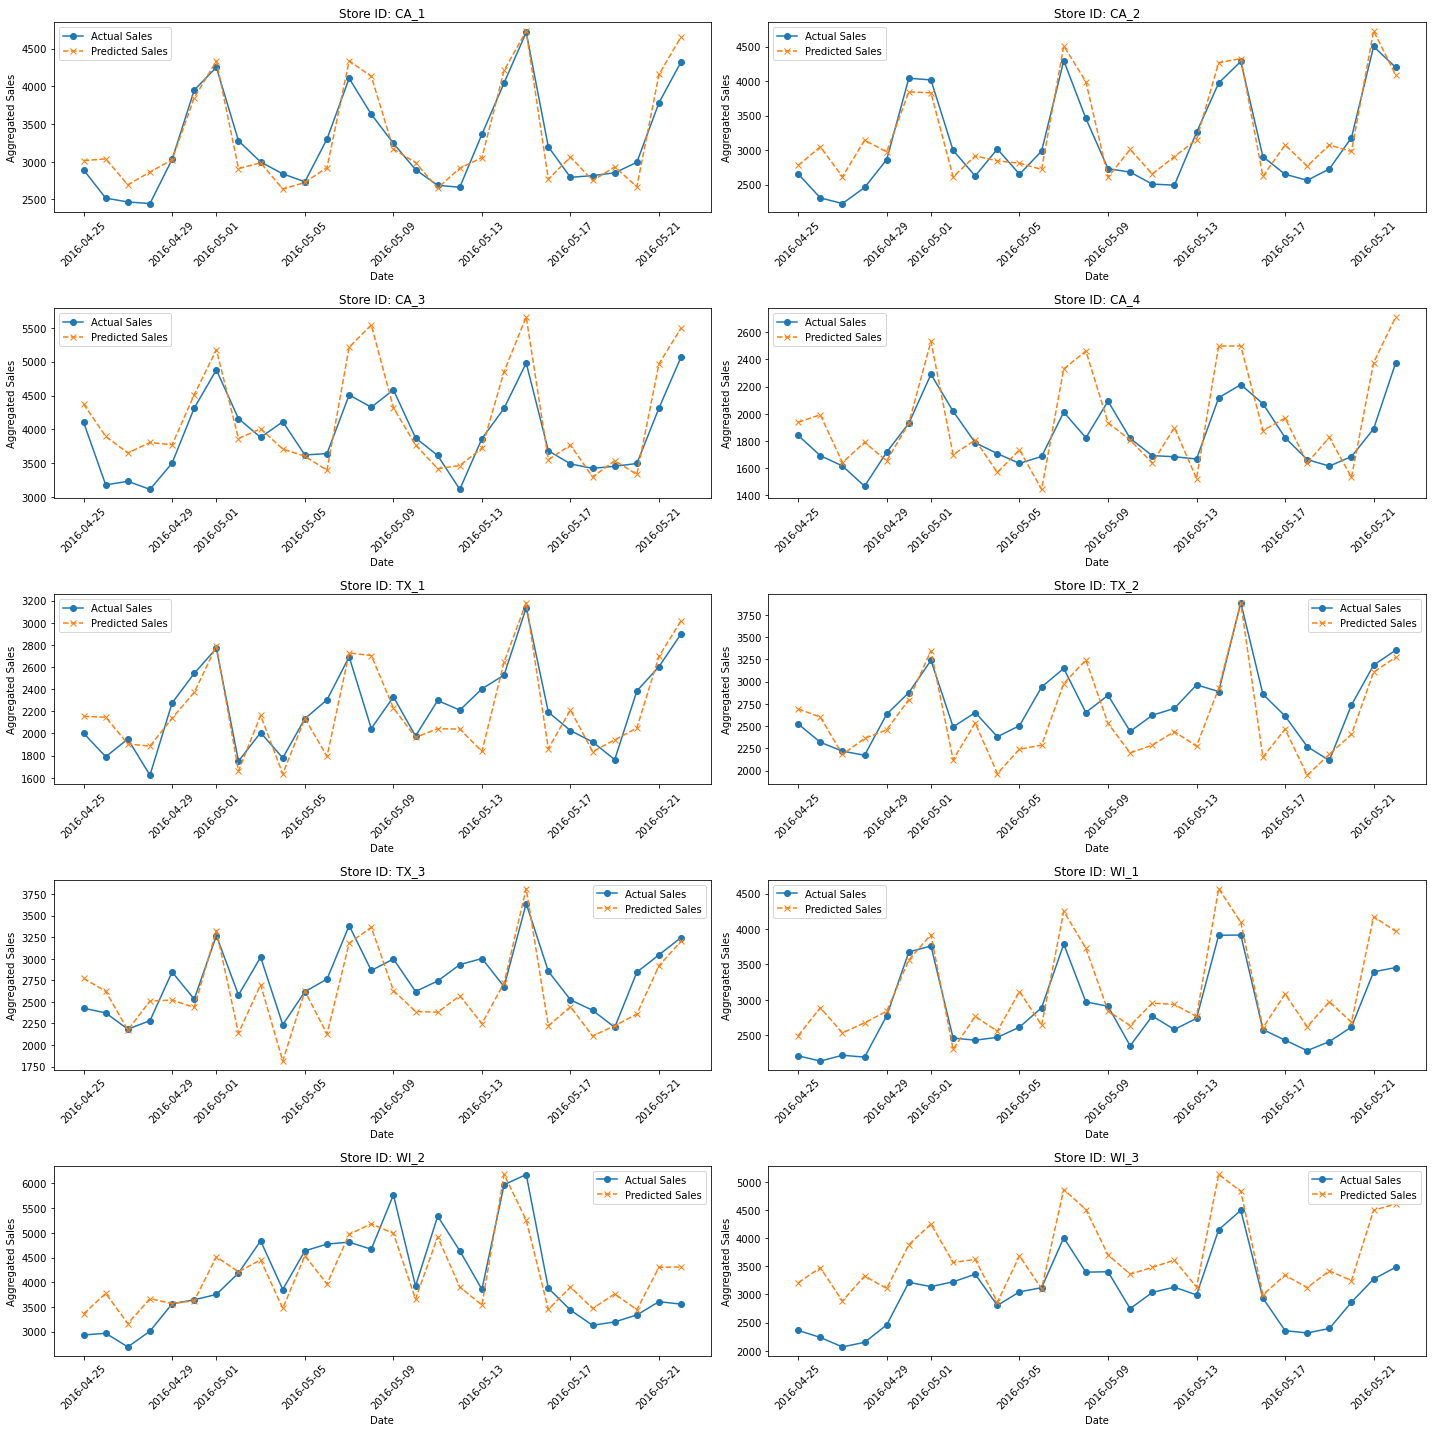

In [96]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming predict_combined_1 is your DataFrame with actual and predicted sales
# And it contains columns 'store_id', 'date', 'sales', and 'Predicted_Values'

# Aggregate sales by store_id and date
store_sales_agg = predict_combined_1.groupby(['store_id', 'date']).agg({
    'sales': 'sum',
    # Ensure only non-missing Predicted_Values are summed; you might adjust this as per your data's representation of missing values
    'Predicted_Values': lambda x: x.dropna().sum()  
}).reset_index()

# Filter out rows where Predicted_Values might be zero or NaN after aggregation
store_sales_agg = store_sales_agg[store_sales_agg['Predicted_Values'] > 0]

# Select unique store_ids (assuming you want to plot for all, adjust as necessary)
unique_store_ids = store_sales_agg['store_id'].unique()

# Plotting
plt.figure(figsize=(20, 20))

for i, store_id in enumerate(unique_store_ids, start=1):
    data = store_sales_agg[store_sales_agg['store_id'] == store_id]

    plt.subplot(len(unique_store_ids) // 2 + len(unique_store_ids) % 2, 2, i)
    plt.plot(data['date'], data['sales'], 'o-', label='Actual Sales')
    # Only plot Predicted_Values if they exist
    if not data['Predicted_Values'].isnull().all():
        plt.plot(data['date'], data['Predicted_Values'], 'x--', label='Predicted Sales')
    plt.title(f'Store ID: {store_id}')
    plt.xlabel('Date')
    plt.ylabel('Aggregated Sales')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.show()
